In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
# from mlxtend.feature_selection import SequentialFeatureSelector
import seaborn as sns
from tqdm import tqdm_notebook
import parfit.parfit as pf
sns.set()

In [2]:
## Create logistic regression estimator
logit = LogisticRegression(C=0.31622777, random_state=17, verbose=1, solver='sag') # C = 0.16681005, 0.14677993, 0.21544347 (in order of desc. perf.)
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', logit)])
stoch = SGDClassifier(loss='log', random_state=17, verbose=0, alpha=0.000095)
clf = logit

In [3]:
## Useful CV generators
time_split = TimeSeriesSplit(n_splits=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

## PolynomialFeatures
poly = PolynomialFeatures(2)

# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
# function to add time features to the data
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)]) #, dayofweek.values.reshape(-1,1)])
    return X

# function to add more features
def add_features(new_feat, X_sparse, scale=False):
    if len(new_feat):
        if scale:
            tmp = StandardScaler().fit_transform([new_feat])
        else:
            tmp = new_feat
        X = hstack([X_sparse, tmp.values.reshape(-1, 1)])
    else:
        X = X_sparse
    return X

with open("../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
#sites_dict.head()

train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
# Sort the data by time
train_df = train_df.sort_values(by='time1')

sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text2.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text2.txt', 
                                              sep=' ', 
                       index=None, header=None)

#cv = CountVectorizer(ngram_range=(1, 3), max_features=50000) # not defining max_features as 50,000 here
cv = TfidfVectorizer(ngram_range=(1, 3), max_features=100000, analyzer='char_wb')

with open('train_sessions_text2.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text2.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)

## This only puts the sites data into a sparse matrix
print('X_train size is: {0} \nX_test size is: {1}'. format(X_train.shape, X_test.shape))

## Train target data is saved separately
y_train = train_df['target'].astype('int')

## full dataset
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# split index
idx_split = train_df.shape[0]

Websites total: 48371
X_train size is: (253561, 1331) 
X_test size is: (82797, 1331)


In [4]:
full_time_df = pd.DataFrame(index=full_df.index)
full_time_df['start_day_of_week'] = full_df['time1'].apply(lambda ts: ts.dayofweek)
full_time_df['session_mins'] = round((full_df[times].max(axis=1)-full_df[times].min(axis=1))
                                      /np.timedelta64(1, 's')/60, 2)
full_time_df['session_secs'] = round((full_df[times].max(axis=1)-full_df[times].min(axis=1))
                                      /np.timedelta64(1, 's'), 2)
full_time_df['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
full_time_df['site_count'] = full_df[sites].count(axis=1)
full_time_df['secs_per_site'] = (round((full_time_df.session_secs/full_time_df.site_count), 2)
                                 .replace([np.inf, -np.inf], 0))

print(full_time_df.shape)

X_train_new = add_time_features(train_df, X_train)
X_test_new = add_time_features(test_df, X_test)
## Augment X_train and X_test sparse matrices with TOU columns
print('X_train_new size is: {0} \nX_test_new size is: {1}'. format(X_train_new.shape, X_test_new.shape))

#full_time_df.head()

(336358, 6)
X_train_new size is: (253561, 1335) 
X_test_new size is: (82797, 1335)


### Investigating Time Features

In [7]:
time_df = pd.DataFrame(index=train_df.index)
time_df['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
time_df['start_day'] = train_df['time1'].apply(lambda ts: ts.day)
time_df['start_month'] = train_df['time1'].apply(lambda ts: ts.month)
time_df['start_day_of_week'] = train_df['time1'].apply(lambda ts: ts.dayofweek)
time_df['session_mins'] = round((train_df[times].max(axis=1)-train_df[times].min(axis=1))
                                /np.timedelta64(1, 's')/60, 2)
time_df['session_secs'] = round((train_df[times].max(axis=1)-train_df[times].min(axis=1))
                                /np.timedelta64(1, 's'), 2)

time_df['target'] = train_df['target']
time_df['stop_hour'] = train_df[times].max(axis=1).apply(lambda ts: ts.hour)
time_df.head()

,start_hour,start_day,start_month,start_day_of_week,session_mins,session_secs,target,stop_hour
session_id,,,,,,,,
21669,8,12,1,5,0.00,0.0,0,8
54843,8,12,1,5,29.77,1786.0,0,9
77292,8,12,1,5,0.07,4.0,0,8
114021,8,12,1,5,0.05,3.0,0,8
146670,8,12,1,5,0.03,2.0,0,8


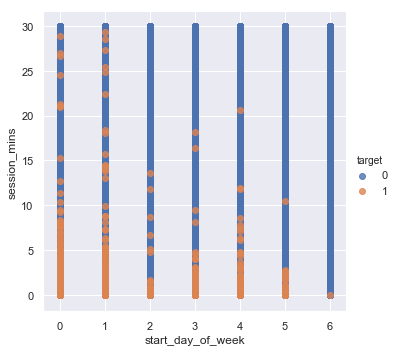

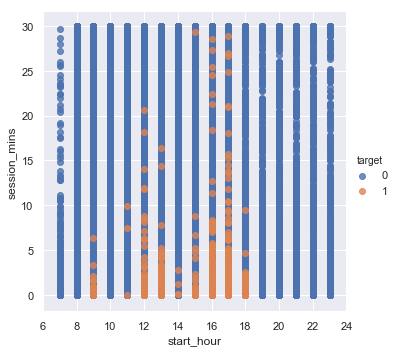

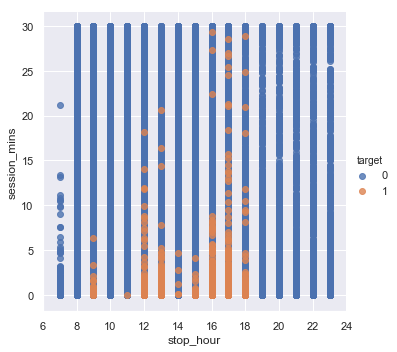

In [12]:
sns.lmplot(x='start_day_of_week', y='session_mins', data=time_df, hue='target', fit_reg=False)
sns.lmplot(x='start_hour', y='session_mins', data=time_df, hue='target', fit_reg=False)
sns.lmplot(y='session_mins', x='stop_hour', data=time_df, hue='target', fit_reg=False)

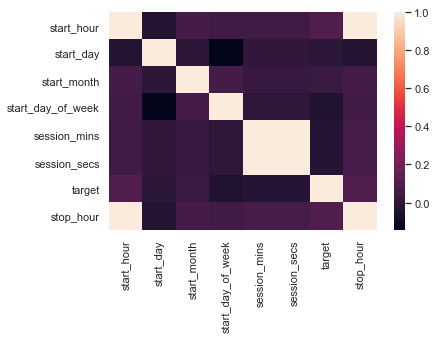

In [13]:
sns.heatmap(time_df.corr())

### Adding relevant time features to Test/Train dataframes

In [8]:
def update_features(train = X_train_new, test = X_test_new, df = full_df, time_df = full_time_df, train_df = train_df):
    X_new = vstack([train, test]) # combine train and test sets
    
    # day of week feature
    dow = (time_df.start_day_of_week<=1).astype('int')
    
    # session secs feature
    s_secs_noScale = time_df.session_mins
#     s_secs = StandardScaler().fit_transform([s_secs_noScale])
    
    # time per site feature
    time_site_noScale = time_df.secs_per_site
    
    # start hour
    start_hour = time_df.start_hour

    
    add_feat_noScale = pd.concat([dow, s_secs_noScale, time_site_noScale], axis=1).values
#     add_feat_noScale = poly.fit_transform(add_feat_noScale)
#     print(add_feat_noScale.shape)
#     print(s_secs_noScale.values.shape, dow.values.shape)
    
#     add_feat_noScale = poly.fit_transform(pd.concat([dow, s_secs_noScale], axis=1).values)
    add_feat = StandardScaler().fit_transform(add_feat_noScale)
    
    tmp = hstack([X_new, add_feat]).tocsr()
    
#     tmp = hstack([X_new, dow.values.reshape(-1,1), 
#                   s_secs.reshape(-1,1)]).tocsr()
    
    X_train, X_test = tmp[:idx_split,:], tmp[idx_split:,:]
    print('X_train size is: {0} \nX_test size is: {1}'
          .format(X_train.shape,X_test.shape))
    return X_train, X_test

In [9]:
%%time
a,b = update_features() # outputs a= X_train_final, b= X_test_final

X_train size is: (253561, 1338) 
X_test size is: (82797, 1338)
Wall time: 2.97 s


### RandomForest

In [31]:
%%time
clf_rf = RandomForestClassifier (random_state=17, n_estimators=100, n_jobs=-1)
cross_score_rf = np.mean(cross_val_score (clf_rf, a, y_train, scoring = 'roc_auc', 
                                          cv = time_split, verbose=5, n_jobs=-1))
print ('Cross validation RandomForestClassifier score:% s ROC AUC'% round (cross_score_rf, 4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 23.3min remaining: 15.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 39.0min finished


Cross validation RandomForestClassifier score:0.8308 ROC AUC
Wall time: 43min 42s


In [ ]:
clf_rf.fit (a, y_train)
rf_test_pred = clf_rf.predict_proba (X_valid) [:, 1]
write_to_submission_file(rf_test_pred, 'km15.csv') 

### Logistic Regression

In [14]:
cv_scores = cross_val_score(clf, a, y_train, cv=time_split, verbose=5, 
                            scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.1min remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


[0.80245853 0.78945368 0.93276183 0.95736399 0.88005093 0.95333339
 0.91388133 0.95807639 0.94556131 0.96624471] 0.9099186089798911


In [15]:
%%time
clf.fit(a, y_train)
logit_test_pred = clf.predict_proba(b)[:, 1]
write_to_submission_file(logit_test_pred, 'km16.csv') 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 68 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


Wall time: 1min 8s


**Performance Tracking**

| Detection Accuracy | Features & Hyperparameter Tuning |
|---|---|
|0.94604| GridSearchCV for reg. param.|
|0.94992| removed 'top_sites' & updated C with value from Log.Reg.CV |
|0.95021| new reg.param. |
|0.94953| using 0.14677993 for C |
|0.94826| trying SGDClassifier |
|0.95034| adding polynomial features |
|0.93549| polynomial features for start hour |
|0.95057| removed hour, increase to 70,000 max features |
|0.95034| added time/site with poly features|


In [17]:
c_values = np.logspace(-1, 1, 10)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=time_split, verbose=0, n_jobs=-1, scoring='roc_auc')

In [18]:
%%time
logit_searcher.fit(a, y_train)

Wall time: 3min 49s


LogisticRegressionCV(Cs=array([ 0.1    ,  0.16681,  0.27826,  0.46416,  0.77426,  1.29155,
        2.15443,  3.59381,  5.99484, 10.     ]),
           class_weight=None,
           cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

In [19]:
logit_searcher.C_ # C = 0.16681005, 0.14677993, 0.21544347 (in order of descending performance)

array([1.29154967])

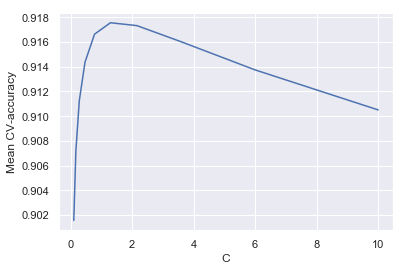

In [20]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

# Highest Accuracy on Test Set = 95.06%